## Lets Voronoi Baby

#### Sources:
- https://towardsdatascience.com/how-to-create-voronoi-regions-with-geospatial-data-in-python-adbb6c5f2134
- https://pypi.org/project/geovoronoi/

#### Get the libs for this project:

In [79]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from shapely.ops import unary_union
from geovoronoi import voronoi_regions_from_coords, points_to_coords
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area

#### Load Files

In [80]:
# pandas data frame from cites in a csv
df1 = pd.read_csv("data/cities.csv")

# geopandas data frame from a geojson file
gdf2 = gpd.read_file("data/cities.geojson")

We need to convert the lat/lon columns to a `geometry` data type. A `Point` to be more specific. Using our csv file and the dataframe (`df1`), we create a `geodataframe` (`gdf1`) using the coordinates in `df1`

In [45]:
gdf1 = gpd.GeoDataFrame(
     df1, geometry=gpd.points_from_xy(df1.lon, df1.lat))
gdf1.head()

,city,growth,lat,lon,population,rank,state,geometry
0,New York,4.8,40.712784,-74.005941,8405837,1,New York,POINT (-74.00594 40.71278)
1,Los Angeles,4.8,34.052234,-118.243685,3884307,2,California,POINT (-118.24368 34.05223)
2,Chicago,-6.1,41.878114,-87.629798,2718782,3,Illinois,POINT (-87.62980 41.87811)
3,Houston,11.0,29.760427,-95.369803,2195914,4,Texas,POINT (-95.36980 29.76043)
4,Philadelphia,2.6,39.952584,-75.165222,1553165,5,Pennsylvania,POINT (-75.16522 39.95258)


However! Reading in the geojson file already has the correct `Point` `geometry` done for us! So from here on down, we could use either `gdf1` or `gdf2`

In [94]:
gdf2.head()

,city,growth,population,rank,state,marker-color,marker-size,geometry
0,Portland,15.0,609456,29,Oregon,#879CB9,medium,POINT (-122.67648 45.52306)
1,Seattle,15.6,652405,21,Washington,#14F334,medium,POINT (-122.33207 47.60621)
2,Los Angeles,4.8,3884307,2,California,#5F2B67,medium,POINT (-118.24368 34.05223)
3,Boise City,9.5,214237,98,Idaho,#94EEF1,medium,POINT (-116.21461 43.61871)
4,Las Vegas,24.5,603488,30,Nevada,#F3E40F,medium,POINT (-115.13983 36.16994)


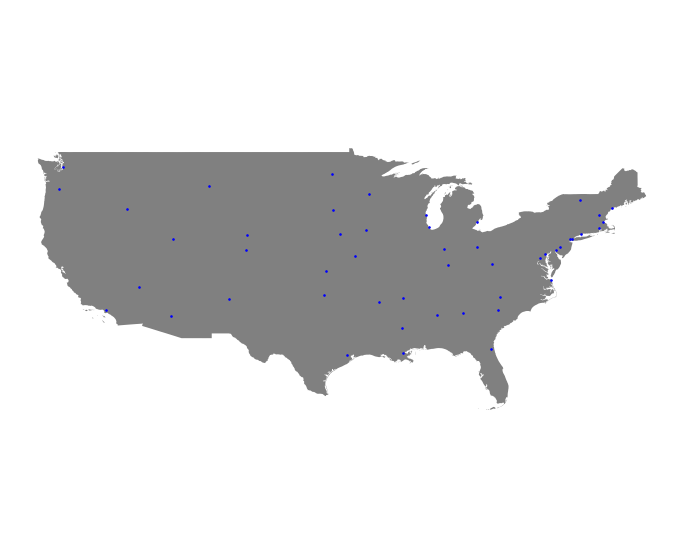

In [102]:

#boundary = gpd.read_file("data/us_nation_border.geojson")
boundary = gpd.read_file("data/us_border_shp/us_border.shp")
fig, ax = plt.subplots(figsize=(12, 10))
boundary.plot(ax=ax, color="gray")
gdf2.plot(ax=ax, markersize=2.5, color="blue")
ax.axis("off")
plt.axis('equal')

# minx, miny, maxx, maxy = gdf2.total_bounds
# print(minx,miny,maxx,maxy)
# ax.set_xlim(minx-5, maxx+5)
# ax.set_ylim(miny, maxy)
plt.show()

Must ensure that the coords are of the correct "projection" type. 

In [90]:
boundary = boundary.to_crs(epsg=3395)
gdf_proj = gdf2.to_crs(boundary.crs)


Convert the "points" to "coords". See the values after the cell to see the difference!

In [104]:
boundary_shape = unary_union(boundary.geometry)

coords = points_to_coords(gdf_proj.geometry)

coords
 

array([[-13656283.50855019,   5673745.36396603],
       [-13617943.85140659,   6010018.39568719],
       [-13162826.80372024,   4011892.6892015 ],
       [-12936950.8739804 ,   5377138.44952307],
       [-12817307.24562408,   4298811.23593637],
       [-12476024.7299865 ,   3931420.55464436],
       [-12455654.37636624,   4949216.42651617],
       [-12078241.56151883,   5715051.523275  ],
       [-11867275.87569534,   4150923.18763879],
       [-11687461.27957798,   4800799.48308428],
       [-11668536.40954567,   5004892.78901347],
       [-10855479.10893892,   4202810.00011476],
       [-10835406.31231755,   4509442.97393323],
       [-10774591.58394126,   5890848.95234786],
       [-10768057.1298317 ,   5365789.27343607],
       [-10686447.14133879,   5021455.49519044],
       [-10616517.90701482,   3451586.29002094],
       [-10528437.91839751,   4709014.52364948],
       [-10420518.01353357,   5072953.22679703],
       [-10382213.53334906,   5587806.02802277],
       [-10273630.72

Create the Voronoi diagram...

In [95]:
region_polys, region_pts = voronoi_regions_from_coords(coords, boundary_shape)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/geovoronoi/_voronoi.py:143: ShapelyDeprecationWarning: The proxy geometries (through the 'asShape()', 'asPoint()' or 'PointAdapter()' constructors) are deprecated and will be removed in Shapely 2.0. Use the 'shape()' function or the standard 'Point()' constructor instead.
  pts = coords_to_points(coords)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/geovoronoi/_voronoi.py:202: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  geom_polys, geom_pts = region_polygons_from_voronoi(vor, geom, return_point_assignments=True, **kwargs)
Exception ignored in: <function BaseGeometry.__del__ at 0x7fd611635af0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/shapely/geometry/base.py", line 209, in __del__
    #     case

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


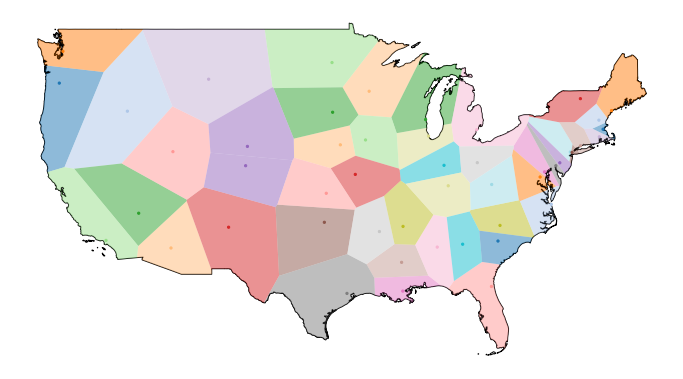

In [101]:
fig, ax = subplot_for_map(figsize=(12, 10))
# gdf1.plot(ax=ax, markersize=2.5, color="blue")
plot_voronoi_polys_with_points_in_area(ax, boundary_shape, region_polys, coords, region_pts)
plt.show()

Traverse the "polygons" created. We could now turn those into a "feature list" to display on `geojson.io` or load each polygon into a spatial index to run queries with them (like find UFO's that are in each polygon). 

In [105]:
for i,poly in region_polys.items():
    print(poly)

POLYGON ((-13187284.82601418 5790595.328698752, -13601600.55492055 4785794.663894219, -13780241.80104186 4732750.418759655, -13781240.63884106 4733564.149090217, -13781781.31760784 4734626.295914849, -13781548.54855259 4735307.957122487, -13781695.9355584 4736485.039114233, -13782620.55524893 4739505.091119709, -13782329.45478051 4741159.358687462, -13783286.46844286 4743228.046119181, -13783811.45116144 4743953.019944582, -13784172.79422855 4746384.369198479, -13784281.33073208 4747516.726122845, -13783838.16783923 4749134.172467247, -13783789.40990226 4752982.277844215, -13782988.24352702 4758684.870587607, -13780867.49590792 4765245.277316823, -13779590.77266801 4767717.345933799, -13778961.92886452 4769450.489585509, -13777620.97427842 4773953.999322257, -13777702.79410416 4774967.697276495, -13779952.22705462 4781398.304335888, -13779520.64138881 4782112.834558645, -13779385.05424903 4783835.546866355, -13779834.56235285 4789371.157732896, -13780535.76382536 4792855.72289889, -137